In [1]:
import numpy as np
import emcee
import matplotlib.pyplot as pl
import corner
import scipy.optimize as op


# Choose the "true" parameters.
m_true = -0.9594
b_true = 4.294

# Generate some synthetic data from the model.
N = 20
x = np.sort(10*np.random.rand(N))
yerr = 0.1+0.5*np.random.rand(N)
xerr = 0.1+0.5*np.random.rand(N)
y = m_true*x+b_true
y += np.abs(1.*y) * np.random.randn(N)
y += yerr * np.random.randn(N)
x+=xerr+0.2*np.random.rand(N)

[m_fit, b_fit], cov  = np.polyfit(x,y, 1, w=1./yerr**2, cov=True, full = False)

print m_fit, b_fit
print cov



-0.9119809937924085 3.3977933570077004
[[ 0.03032657 -0.15557291]
 [-0.15557291  0.93968792]]


In [2]:
def lnlike(theta, x, y, xerr, yerr):
    m, b = theta
    model = m * x + b
    inv_sigma2 = 1.0/(yerr**2 + (m*xerr)**2)
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(inv_sigma2)))

nll = lambda *args: -lnlike(*args)
result = op.minimize(nll, [m_true, b_true], args=(x, y, xerr, yerr))
m_ml, b_ml = result["x"]

print result["x"]
print result

[-0.89366026  3.69955157]
      fun: 153.07867226846582
 hess_inv: array([[ 0.00183154, -0.00863697],
       [-0.00863697,  0.05244874]])
      jac: array([7.62939453e-06, 1.90734863e-06])
  message: 'Optimization terminated successfully.'
     nfev: 44
      nit: 8
     njev: 11
   status: 0
  success: True
        x: array([-0.89366026,  3.69955157])


<ErrorbarContainer object of 3 artists>

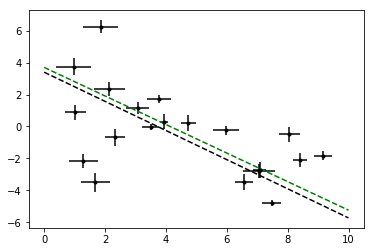

In [3]:
xl = np.array([0, 10])
pl.plot(xl, m_fit*xl+b_fit, "--", color='black')
pl.plot(xl, m_ml*xl+b_ml, "g--")

pl.errorbar(x, y, xerr=xerr, yerr=yerr, fmt=".k")


In [4]:
def lnprior(theta):
    m, b = theta
    if True:  # don't care
        return 0.0
    return -np.inf
# m_true = -0.9594
# b_true = 4.294
def lnprob(theta, x, y, xerr, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, xerr, yerr)

(-0.8968363461110109, 0.040937749024762216, 0.044431946981099646) (3.716038507794652, 0.2474486585929876, 0.22932297005866342)


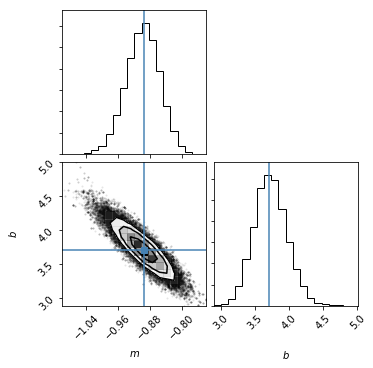

In [5]:
ndim, nwalkers = 2, 100
pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y, xerr, yerr))
sampler.run_mcmc(pos, 1000)
samples = sampler.chain[:, 100:, :].reshape((-1, ndim))
#samples[:,1][0:10]
fig = corner.corner(samples, labels=["$m$", "$b$"],
                      truths=[m_ml, b_ml])

m_mcmc, b_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],
                                                axis=0)))
print m_mcmc, b_mcmc

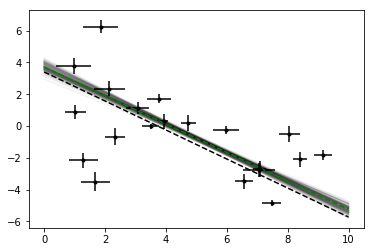

In [6]:
xl = np.array([0, 10])
pl.plot(xl, m_fit*xl+b_fit, "--", color='black')
pl.errorbar(x, y, xerr=xerr, yerr=yerr, fmt=".k")
for m, b, in samples[np.random.randint(len(samples), size=100)]:
    pl.plot(xl, m*xl+b, color="k", alpha=0.05)
pl.plot(xl, m_ml*xl+b_ml, "g--")


In [7]:
from linear_mcmc import *

m,b,samples=linMC(x, y, xerr, yerr)
print m
print b

(-0.8957870299614322, 0.04405255438784328, 0.045025951192345204)
(3.7130144620628336, 0.24851991124907613, 0.24999964733967373)


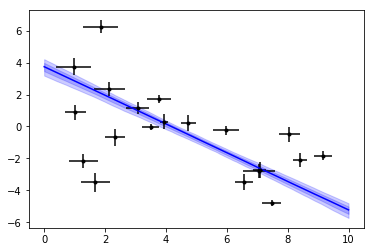

In [8]:
size = 200
xl = np.linspace(0,10,1000)


N = len(xl)
Y = np.ones(shape = (size,N))
i = 0 
for m, b, in samples[np.random.randint(len(samples), size=size)]:
    Y[i] = m*xl+b
    i+=1

U = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(Y, [16, 50, 84],
                                                axis=0)))
yl = np.asarray([item[0] for item in U])
yue = np.asarray([item[1] for item in U])
yle = np.asarray([item[2] for item in U])

pl.errorbar(x, y, xerr=xerr, yerr=yerr, fmt=".k")


pl.fill_between(xl, yl+2*yue, yl-2*yle, color='b', alpha=0.2,
                 edgecolor="none")
pl.fill_between(xl, yl+yue, yl-yle, color='b', alpha=0.2,
                 edgecolor="none")
pl.plot(xl, yl, color='b')

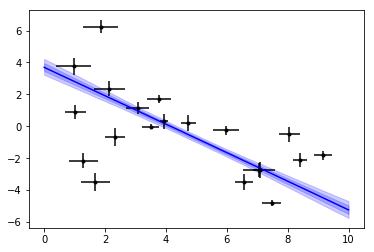

In [12]:
yl, yue, yle = linSimul(samples, xl, 500, percentile=[16, 50, 84])
pl.errorbar(x, y, xerr=xerr, yerr=yerr, fmt=".k")


pl.fill_between(xl, yl+2*yue, yl-2*yle, color='b', alpha=0.2,
                 edgecolor="none")
pl.fill_between(xl, yl+yue, yl-yle, color='b', alpha=0.2,
                 edgecolor="none")
pl.plot(xl, yl, color='b')